# TODO:
#### João:
- [x] cena das datas passar horas para tarde/noite/manha/madrugada && dividr dias do mes e mes // Semi Done not sure what to do with month and days divider
- [x] nominal to numeric | NOminal value discretization using label Encoding
- [] outliers
- [] noise  NOTE: Binning is a technique for data smoothing. Data smoothing is employed to removenoise from data.
- [x] duplicated Records 

#### Jorge
- [x] Binning
- [x] feature scalling
- [x] svn
- [x] training and testing data

# Dados e Aprendizagem Automática
## Trabalho Prático
### Grupo 13
### Membros:
- (PG50304) Cristiano Pereira
- (PG50463) João Martins
- (PG50506) Jorge Lima
- (PG50733) Rúben Santos

Notebook structure:
- 1. Importing libraries
- 2. Loading the dataset
- 3. Exploratory Data Analysis TODO Joao
- 4. Data Preprocessing TODO Joao
- 5. Model Training TODO Jorge
- 6. Model Evaluation TODO Jorge
- 8. Conclusion Todo

## 1. Importing libraries

In [1]:
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, tree, metrics, model_selection, linear_model
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


# Lois
from lois import lois_ds_report
%matplotlib inline

## 2. Loading the dataset

In [2]:
trainingData = pd.read_csv('data/training_data.csv')
testData = pd.read_csv('data/test_data.csv')

## 3. Exploratory Data Analysis TODO Joao

╭─────────────────────────────────────────── Exploratory Data Anlysis ────────────────────────────────────────────╮
│                                                                                                                 │
╰──────────────────────────────────── EDA|simple| Suitable for data scientist ────────────────────────────────────╯

EDA
┗━━ Dataset Shape Analysis
    ┣━━ Dataset head
    ┣━━ General info 
    ┣━━ The target variable
    ┣━━ Number of rows and columns
    ┣━━ The different data types
    ┃   ┣━━ The sum of different variable type
    ┃   ┗━━ Visual representation of different variable type
    ┗━━ Analyze missing value
        ┣━━ The percentage of missing value in each columns
        ┣━━ The missing value counts
        ┗━━ Visual representation of missing value

╭──────────────────────────────────────────── DATASET SHAPE ANALYSIS ─────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

-------------------- THE HEAD OF YOUR DATASET --------------------

Your dataset is too large ; only the first 8 columns will be display

                                                    The Dataset                                                    
┏━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ city… ┃ magnitude_of_… ┃ delay_in_se… ┃ affected_… ┃ record… ┃ lumin… ┃ avg_tempera… ┃ avg_atm_pre… ┃ avg_humi… ┃
┡━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
└───────┴────────────────┴──────────────┴────────────┴─────────┴────────┴──────────────┴──────────────┴───────────┘

-------------------- SOME GENERAL INFO ABOUT YOUR DATASET --------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city_name           5000 non-null   object 
 1   magnitude_of_delay  5000 non-null   object 
 2   delay_in_seconds    5000 non-null   int64  
 3   affected_roads      4915 non-null   object 
 4   record_date         5000 non-null   object 
 5   luminosity          5000 non-null   object 
 6   avg_temperature     5000 non-null   float64
 7   avg_atm_pressure    5000 non-null   float64
 8   avg_humidity        5000 non-null   float64
 9   avg_wind_speed      5000 non-null   float64
 10  avg_precipitation   5000 non-null   float64
 11  avg_rain            5000 non-null   object 
 12  incidents           5000 non-null   object 
dtypes: float64(5), int64(1), object(7)
memory usage: 507.9+ KB


-------------------- THE TARGET VARIABLE OF YOUR DATASET --------------------

╭───────────────────────────────────────╮
│ The Target variable is : 'incidents'  │
╰───────────────────────────────────────╯

-------------------- ROWS AND COLUMNS IN YOUR DATASET --------------------

╭─ Shape output ─╮
│ (5000, 13)     │
╰────────────────╯

╭────────────────────────────────────────────────╮
│ Your dataset contains 5000 Rows and 13 Columns │
╰────────────────────────────────────────────────╯

-------------------- THE DATA TYPES IN YOUR DATASET --------------------

╭─ Data types output ─╮
│ object     7        │
│ float64    5        │
│ int64      1        │
│ dtype: int64        │
╰─────────────────────╯

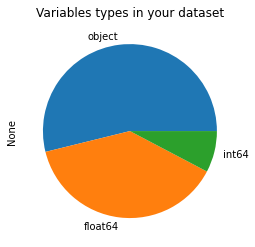

-------------------- MISSING VALUE IN YOUR DATASET --------------------

╭─── Missing value output ────╮
│ city_name             0.000 │
│ magnitude_of_delay    0.000 │
│ delay_in_seconds      0.000 │
│ record_date           0.000 │
│ luminosity            0.000 │
│ avg_temperature       0.000 │
│ avg_atm_pressure      0.000 │
│ avg_humidity          0.000 │
│ avg_wind_speed        0.000 │
│ avg_precipitation     0.000 │
│ avg_rain              0.000 │
│ incidents             0.000 │
│ affected_roads        0.017 │
│ dtype: float64              │
╰─────────────────────────────╯

╭─ Missing value counts output ─╮
│ 0.017     1                   │
│ 0.000    12                   │
│ dtype: int64                  │
╰───────────────────────────────╯

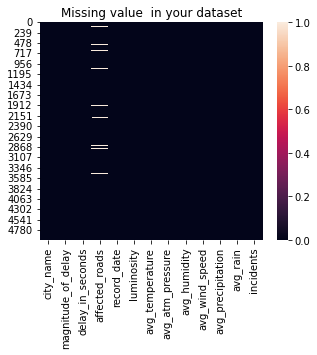

#################### END ####################

In [3]:
lois_ds_report(trainingData,target_variable="incidents")

In [4]:
trainingData.head()

,city_name,magnitude_of_delay,delay_in_seconds,affected_roads,record_date,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_precipitation,avg_rain,incidents
0,Guimaraes,UNDEFINED,0,",",2021-03-15 23:00,DARK,12.0,1013.0,70.0,1.0,0.0,Sem Chuva,None
1,Guimaraes,UNDEFINED,385,"N101,",2021-12-25 18:00,DARK,12.0,1007.0,91.0,1.0,0.0,Sem Chuva,None
2,Guimaraes,UNDEFINED,69,",",2021-03-12 15:00,LIGHT,14.0,1025.0,64.0,0.0,0.0,Sem Chuva,Low
3,Guimaraes,MAJOR,2297,"N101,R206,N105,N101,N101,N101,N101,N101,N101,N...",2021-09-29 09:00,LIGHT,15.0,1028.0,75.0,1.0,0.0,Sem Chuva,Very_High
4,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101,",2021-06-13 11:00,LIGHT,27.0,1020.0,52.0,1.0,0.0,Sem Chuva,High


In [5]:
trainingData.describe()
#TODO: delay_in_seconds might have outliers the rest (seems) fine

,delay_in_seconds,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_precipitation
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.0
mean,560.567000,14.583000,1018.145000,74.455000,1.253500,0.0
std,1686.859581,4.820514,5.174372,17.204638,1.269847,0.0
min,0.000000,1.000000,997.000000,6.000000,0.000000,0.0
25%,0.000000,11.000000,1015.000000,63.000000,0.000000,0.0
50%,0.000000,14.000000,1019.000000,78.000000,1.000000,0.0
75%,234.000000,18.000000,1022.000000,90.000000,2.000000,0.0
max,31083.000000,35.000000,1032.000000,100.000000,10.000000,0.0


In [6]:
trainingData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city_name           5000 non-null   object 
 1   magnitude_of_delay  5000 non-null   object 
 2   delay_in_seconds    5000 non-null   int64  
 3   affected_roads      4915 non-null   object 
 4   record_date         5000 non-null   object 
 5   luminosity          5000 non-null   object 
 6   avg_temperature     5000 non-null   float64
 7   avg_atm_pressure    5000 non-null   float64
 8   avg_humidity        5000 non-null   float64
 9   avg_wind_speed      5000 non-null   float64
 10  avg_precipitation   5000 non-null   float64
 11  avg_rain            5000 non-null   object 
 12  incidents           5000 non-null   object 
dtypes: float64(5), int64(1), object(7)
memory usage: 507.9+ KB


## 4. Data Preprocessing TODO Joao

### Look for any Duplicated Values

In [7]:
#NO duplicated values
trainingData[trainingData.duplicated()]


,city_name,magnitude_of_delay,delay_in_seconds,affected_roads,record_date,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_precipitation,avg_rain,incidents


### Handle missing values

In [8]:
# collum affected_roles to numeric

def count_roads(affected_roads):
    #check if affected_roads is a float(nan values)
    if isinstance(affected_roads, float) and np.isnan(affected_roads):
        return 0
    return len(affected_roads.split(','))

# count the number of different roads affected
def count_roads(affected_roads):
    #check if affected_roads is a float(nan values)
    if isinstance(affected_roads, float) and np.isnan(affected_roads):
        return 0
    result = []
    return len([result.append(x) for x in affected_roads.split(',') if x not in result] )


trainingData['number_affected_roads'] = trainingData['affected_roads'].apply(count_roads)
testData['number_affected_roads'] = testData['affected_roads'].apply(count_roads)
trainingData['number_different_affected_roads'] = trainingData['affected_roads'].apply(count_roads)
testData['number_different_affected_roads'] = testData['affected_roads'].apply(count_roads)

print(trainingData.head())

   city_name magnitude_of_delay  delay_in_seconds  \
0  Guimaraes          UNDEFINED                 0   
1  Guimaraes          UNDEFINED               385   
2  Guimaraes          UNDEFINED                69   
3  Guimaraes              MAJOR              2297   
4  Guimaraes          UNDEFINED                 0   

                                      affected_roads       record_date  \
0                                                  ,  2021-03-15 23:00   
1                                              N101,  2021-12-25 18:00   
2                                                  ,  2021-03-12 15:00   
3  N101,R206,N105,N101,N101,N101,N101,N101,N101,N...  2021-09-29 09:00   
4                          N101,N101,N101,N101,N101,  2021-06-13 11:00   

  luminosity  avg_temperature  avg_atm_pressure  avg_humidity  avg_wind_speed  \
0       DARK             12.0            1013.0          70.0             1.0   
1       DARK             12.0            1007.0          91.0             

---

In [9]:
#testing if exists null values
# TODO: Correct to drop the affected_roads collumn?
trainingData.drop('affected_roads', axis=1, inplace=True)
testData.drop('affected_roads', axis=1, inplace=True)
trainingData.isna().any()

city_name                          False
magnitude_of_delay                 False
delay_in_seconds                   False
record_date                        False
luminosity                         False
avg_temperature                    False
avg_atm_pressure                   False
avg_humidity                       False
avg_wind_speed                     False
avg_precipitation                  False
avg_rain                           False
incidents                          False
number_affected_roads              False
number_different_affected_roads    False
dtype: bool

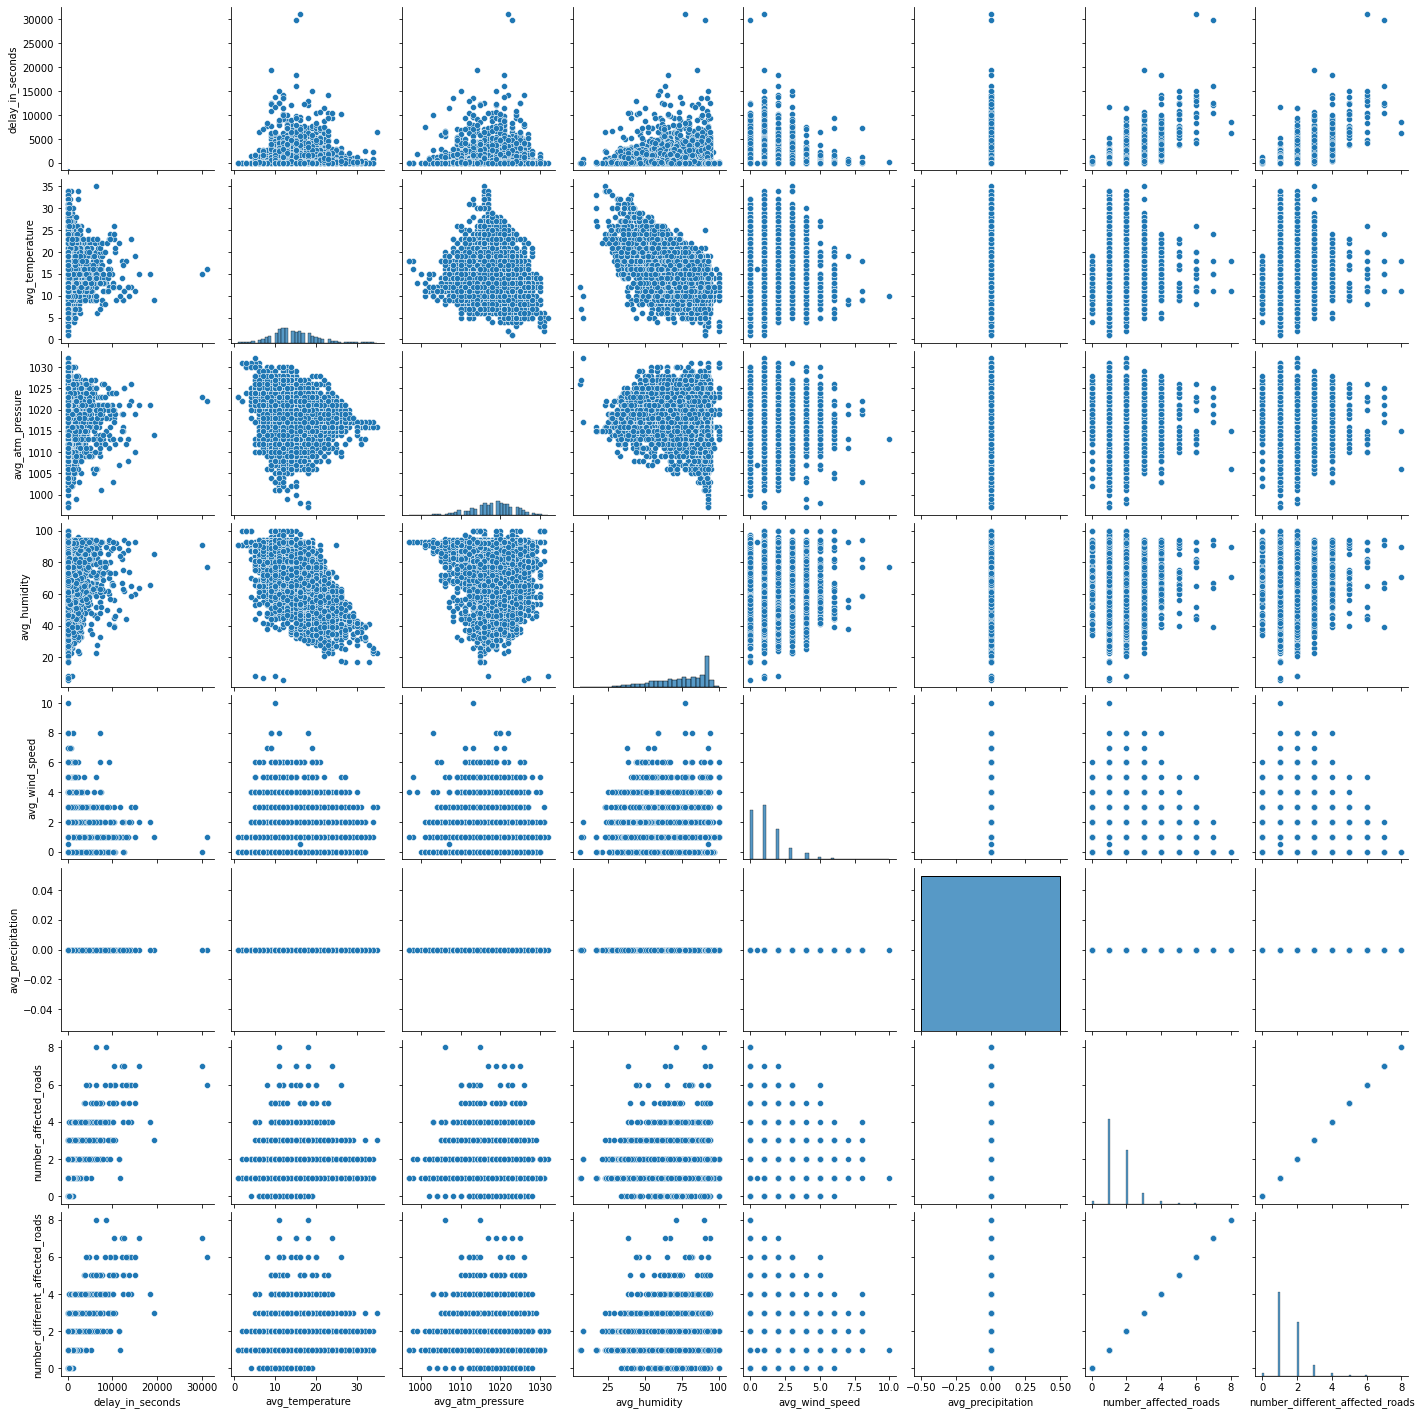

In [10]:
sns.pairplot(trainingData)

In [11]:
trainingData.profile_report(minimal=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

##### Dropping city_name because it's only data from Guimaraes

In [12]:
#Remove city_name column, only guimaraes is present
trainingData.drop('city_name',axis=1,inplace=True)
testData.drop('city_name',axis=1,inplace=True)


# Turn values to Numeric

###  Turn nominal values to numeric

In [13]:
dict_magnitude_of_delay = {'UNDEFINED': 0, 'MODERATE':1, 'MAJOR':3}
trainingData['magnitude_of_delay'] = trainingData['magnitude_of_delay'].map(dict_magnitude_of_delay)
testData['magnitude_of_delay'] = testData['magnitude_of_delay'].map(dict_magnitude_of_delay)

dict_luminosity = {'LOW_LIGHT': 0, 'LIGHT':1, 'DARK':2}
trainingData['luminosity'] = trainingData['luminosity'].map(dict_luminosity)
testData['luminosity'] = testData['luminosity'].map(dict_luminosity)

dict_avg_rain = {'Sem Chuva': 0, 'chuva fraca': 1, 'chuva moderada': 2, 'chuva forte': 3}
trainingData['avg_rain'] = trainingData['avg_rain'].map(dict_avg_rain)
testData['avg_rain'] = testData['avg_rain'].map(dict_avg_rain)

#### categorizing time of day

In [14]:
# Turn column record_date into manha,tarde,noite or madrugada
def turn_date_into_time_of_day(record_date):
    hour = int(record_date.split(' ')[1].split(':')[0])
    if hour >= 6 and hour < 12:
        return 'manha'
    elif hour >= 12 and hour < 18:
        return 'tarde'
    elif hour >= 18 and hour < 24:
        return 'noite'
    else:
        return 'madrugada'


trainingData['time_of_day'] = trainingData['record_date'].apply(turn_date_into_time_of_day)
testData['time_of_day'] = testData['record_date'].apply(turn_date_into_time_of_day)

dict_time_of_day = {'manha': 0, 'tarde':1, 'noite':2, 'madrugada':3}
trainingData['time_of_day'] = trainingData['time_of_day'].map(dict_time_of_day)
testData['time_of_day'] = testData['time_of_day'].map(dict_time_of_day)

In [15]:
#add 2 column with the month and day from time_of_day
trainingData['month'] = pd.DatetimeIndex(trainingData['record_date']).month
testData['month'] = pd.DatetimeIndex(testData['record_date']).month
trainingData['day'] = pd.DatetimeIndex(trainingData['record_date']).day
testData['day'] = pd.DatetimeIndex(testData['record_date']).day

In [16]:
corr_matrix = trainingData.corr(numeric_only=True)
sns.heatmap(corr_matrix,square=True, annot=True)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ <ipython-input-16-1fa3fbac7da4>:1 in <module>                                                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: corr() got an unexpected keyword argument 'numeric_only'

### Binning

In [17]:
from sklearn.preprocessing import KBinsDiscretizer

def apply_binning(data, column, n_bins, encode='ordinal', strategy='quantile'):
    if column in data.columns:
        estimater = KBinsDiscretizer(n_bins=n_bins, encode=encode, strategy=strategy)
        data[column + "_binned"] = estimater.fit_transform(data[[column]])
        data.drop(column, axis=1, inplace=True)


#apply_binning(testingData, 'avg_atm_pressure', 5)

### Normalization

In [18]:
# Normalization
from sklearn.preprocessing import MinMaxScaler

def apply_normalization(data, column):
    if column in data.columns:
        scaler = MinMaxScaler()
        data[column + "_normalized"] = scaler.fit_transform(data[[column]])
        data.drop(column, axis=1, inplace=True)

#apply_normalization(testingData, 'delay_in_seconds')

### Standardization

In [19]:
# Standardization
from sklearn.preprocessing import StandardScaler

def apply_standardization(data, column):
    if column in data.columns:
        scaler = StandardScaler()
        data[column + "_standardized"] = scaler.fit_transform(data[[column]])
        data.drop(column, axis=1, inplace=True)

#apply_standardization(testingData, 'avg_humidity')

## 5. Models Training TODO Jorge

In [20]:
""" Save results to a file. """
def saveResults ( results, path ):
    file = open(path, 'w')
    file.write ("RowId,Incidents\n")
    i = 1
    for result in results :
        file.write (str(i) + "," + result + "\n")
        i += 1

In [21]:
# run for test or run for submission
results_to_test = True

# split data into train and test
trainData = trainingData.copy()
ttData = testData.copy()

if results_to_test:
    y = trainData['incidents']
    x = trainData.drop(['record_date','incidents','number_affected_roads'], axis=1) # TODO REMOVER
    
    x_training, x_testing, y_training, y_testing = model_selection.train_test_split(x, y, test_size=0.5, random_state=2022)

else :
    x_testing = ttData.copy()
    y_training = trainData['incidents'] 
    x_training = trainData.drop(['record_date','incidents','number_affected_roads'], axis=1)


### 5.1 Regressão Logística

In [22]:
logmodel = linear_model.LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
logmodel.fit(x_training,y_training)
logistic_regression_predictions = logmodel.predict(x_testing)

### 5.2 Árvores de Decisão e Classificação

In [23]:
dtc = tree.DecisionTreeClassifier(random_state=2022, criterion="gini", max_depth=10)
dtc.fit(x_training,y_training)
decision_trees_predictions = dtc.predict(x_testing)

### 5.3 Maquinas de Vectores de Suporte (SVM)

In [24]:
df_feat = pd.DataFrame(x_training, columns=x_training.columns)
df_target = pd.DataFrame(y_training, columns=['incidents'])

# 10-Fold Cross Validation
cross_valid_model = SVC(random_state=2022)
cross_val_score(cross_valid_model, df_feat, np.ravel(df_target), cv=10)

array([0.524, 0.544, 0.528, 0.516, 0.556, 0.572, 0.548, 0.56 , 0.544,
       0.524])

### 5.4 Hold-out

In [25]:
model = SVC(random_state=2022)
model.fit(x_training, y_training)
hold_out_predictions = model.predict(x_testing)

### 5.5 Grid Search

In [26]:
#param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']}
#grid = GridSearchCV(SVC(random_state=2022), param_grid, refit=True, verbose=3)
#grid.fit(x_training, y_training)
#grid_predictions = grid.predict(x_testing)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.406 total time=   0.5s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.406 total time=   0.5s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.406 total time=   0.5s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.406 total time=   0.4s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.404 total time=   0.5s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.406 total time=   0.4s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.406 total time=   0.4s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.406 total time=   0.4s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.406 total time=   0.4s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.404 total time=   0.4s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.440 total time=   0.3s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

### 5.6 KNeighborsClassifier

In [27]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_training, y_training)
knn_predictions = knn.predict(x_testing)

### 5.7 GaussianProcessClassifier

In [28]:
#gaussian = GaussianProcessClassifier(n_restarts_optimizer=0, max_iter_predict=100, random_state=2022)
#gaussian.fit(x_training, y_training)
#gaussian_predictions = gaussian.predict(x_testing)

### 5.8 RandomForestClassifier

In [29]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=2022)
random_forest.fit(x_training, y_training)
random_forest_predictions = random_forest.predict(x_testing)

### 5.9 MLPClassifier

In [30]:
mlpclass = MLPClassifier(alpha=1, max_iter=1000)
mlpclass.fit(x_training, y_training)
mlpclass_predictions = mlpclass.predict(x_testing)

### 5.10 AdaBoostClassifier

In [31]:
adaBoost = AdaBoostClassifier(n_estimators=100, random_state=2022)
adaBoost.fit(x_training, y_training)
adaBoost_predictions = adaBoost.predict(x_testing)

### 5.11 GaussianNB

In [32]:
gaussianNB = GaussianNB()
gaussianNB.fit(x_training, y_training)
gaussianNB_predictions = gaussianNB.predict(x_testing)

### 5.12 QuadraticDiscriminantAnalysis

In [33]:
quadraticDiscriminantAnalysis = QuadraticDiscriminantAnalysis()
quadraticDiscriminantAnalysis.fit(x_training, y_training)
quadraticDiscriminantAnalysis_predictions = quadraticDiscriminantAnalysis.predict(x_testing)

/home/rubensas/anaconda3/envs/DAA/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


## 6. Model Evaluation TODO Jorge

In [34]:
if results_to_test:

    results = []
    results_table = []

    # 5.1 Regressão Logística
    logistic_regression_classification = metrics.classification_report(y_testing, logistic_regression_predictions, zero_division=0)
    logistic_regression_classification_dict = metrics.classification_report(y_testing, logistic_regression_predictions, output_dict=True, zero_division=0)
    results_table.append({'model': 'Regressão Logística', 'table': logistic_regression_classification})
    results.append({
        'model': 'Regressão Logística',
        'accuracy': logistic_regression_classification_dict['accuracy'],
        'precision': logistic_regression_classification_dict['macro avg']['precision'],
        'recall': logistic_regression_classification_dict['macro avg']['recall'],
        'f1-score': logistic_regression_classification_dict['macro avg']['f1-score'],
        })

    # 5.2 Decision Tree
    decision_trees_classification = metrics.classification_report(y_testing, decision_trees_predictions, zero_division=0)
    decision_trees_classification_dict = metrics.classification_report(y_testing, decision_trees_predictions, output_dict=True, zero_division=0)
    results_table.append({'model': 'Decision Tree', 'table': decision_trees_classification})
    results.append({
        'model': 'Decision Tree',
        'accuracy': decision_trees_classification_dict['accuracy'],
        'precision': decision_trees_classification_dict['macro avg']['precision'],
        'recall': decision_trees_classification_dict['macro avg']['recall'],
        'f1-score': decision_trees_classification_dict['macro avg']['f1-score']
        })

    # 5.4 Hold Out
    hold_out_classification = metrics.classification_report(y_testing, hold_out_predictions, zero_division=0)
    hold_out_classification_dict = metrics.classification_report(y_testing, hold_out_predictions, output_dict=True, zero_division=0)
    results_table.append({'model': 'Hold Out', 'table': hold_out_classification})
    results.append({
        'model': 'Hold Out',
        'accuracy': hold_out_classification_dict['accuracy'],
        'precision': hold_out_classification_dict['macro avg']['precision'],
        'recall': hold_out_classification_dict['macro avg']['recall'],
        'f1-score': hold_out_classification_dict['macro avg']['f1-score']
        })

    # 5.5 Grid Search
    #grid_classification = metrics.classification_report(y_testing, grid_predictions, zero_division=0)
    #grid_classification_dict = metrics.classification_report(y_testing, grid_predictions, output_dict=True, zero_division=0)
    #results_table.append({'model': 'Grid Search', 'table': grid_classification})
    #results.append({
    #    'model': 'Grid Search',
    #    'accuracy': grid_classification_dict['accuracy'],
    #    'precision': grid_classification_dict['macro avg']['precision'],
    #    'recall': grid_classification_dict['macro avg']['recall'],
    #    'f1-score': grid_classification_dict['macro avg']['f1-score']
    #    })

    #  5.6 KNN
    knn_classification = metrics.classification_report(y_testing, knn_predictions, zero_division=0)
    knn_classification_dict = metrics.classification_report(y_testing, knn_predictions, output_dict=True, zero_division=0)
    results_table.append({'model': 'KNN', 'table': knn_classification})
    results.append({
        'model': 'KNN',
        'accuracy': knn_classification_dict['accuracy'],
        'precision': knn_classification_dict['macro avg']['precision'],
        'recall': knn_classification_dict['macro avg']['recall'],
        'f1-score': knn_classification_dict['macro avg']['f1-score']
        })

    # 5.7 Gaussian
    #gaussian_classification = metrics.classification_report(y_testing, gaussian_predictions, zero_division=0)
    #gaussian_classification_dict = metrics.classification_report(y_testing, gaussian_predictions, output_dict=True, zero_division=0)
    #results_table.append({'model': 'Gaussian', 'table': gaussian_classification})
    #results.append({
    #    'model': 'Gaussian',
    #    'accuracy': gaussian_classification_dict['accuracy'],
    #    'precision': gaussian_classification_dict['macro avg']['precision'],
    #    'recall': gaussian_classification_dict['macro avg']['recall'],
    #    'f1-score': gaussian_classification_dict['macro avg']['f1-score']
    #    })

    # 5.8 Random Forest
    random_forest_classification = metrics.classification_report(y_testing, random_forest_predictions, zero_division=0)
    random_forest_classification_dict = metrics.classification_report(y_testing, random_forest_predictions, output_dict=True, zero_division=0)
    results_table.append({'model': 'Random Forest', 'table': random_forest_classification})
    results.append({
        'model': 'Random Forest',
        'accuracy': random_forest_classification_dict['accuracy'],
        'precision': random_forest_classification_dict['macro avg']['precision'],
        'recall': random_forest_classification_dict['macro avg']['recall'],
        'f1-score': random_forest_classification_dict['macro avg']['f1-score']
        })

    # 5.9 MLP
    mlp_classification = metrics.classification_report(y_testing, mlpclass_predictions, zero_division=0)
    mlp_classification_dict = metrics.classification_report(y_testing, mlpclass_predictions, output_dict=True, zero_division=0)
    results_table.append({'model': 'MLP', 'table': mlp_classification})
    results.append({
        'model': 'MLP',
        'accuracy': mlp_classification_dict['accuracy'],
        'precision': mlp_classification_dict['macro avg']['precision'],
        'recall': mlp_classification_dict['macro avg']['recall'],
        'f1-score': mlp_classification_dict['macro avg']['f1-score']
        })
    
    # 5.10 AdaBoost
    adaBoost_classification = metrics.classification_report(y_testing, adaBoost_predictions, zero_division=0)
    adaBoost_classification_dict = metrics.classification_report(y_testing, adaBoost_predictions, output_dict=True, zero_division=0)
    results_table.append({'model': 'AdaBoost', 'table': adaBoost_classification})
    results.append({
        'model': 'AdaBoost',
        'accuracy': adaBoost_classification_dict['accuracy'],
        'precision': adaBoost_classification_dict['macro avg']['precision'],
        'recall': adaBoost_classification_dict['macro avg']['recall'],
        'f1-score': adaBoost_classification_dict['macro avg']['f1-score']
        })

    # 5.11 GaussianNB
    gaussianNB_classification = metrics.classification_report(y_testing, gaussianNB_predictions, zero_division=0)
    gaussianNB_classification_dict = metrics.classification_report(y_testing, gaussianNB_predictions, output_dict=True, zero_division=0)
    results_table.append({'model': 'GaussianNB', 'table': gaussianNB_classification})
    results.append({
        'model': 'GaussianNB',
        'accuracy': gaussianNB_classification_dict['accuracy'],
        'precision': gaussianNB_classification_dict['macro avg']['precision'],
        'recall': gaussianNB_classification_dict['macro avg']['recall'],
        'f1-score': gaussianNB_classification_dict['macro avg']['f1-score']
        })
    
    # 5.12 Quadratic Discriminant Analysis
    qda_classification = metrics.classification_report(y_testing, quadraticDiscriminantAnalysis_predictions, zero_division=0)
    qda_classification_dict = metrics.classification_report(y_testing, quadraticDiscriminantAnalysis_predictions, output_dict=True, zero_division=0)
    results_table.append({'model': 'Quadratic Discriminant Analysis', 'table': qda_classification})
    results.append({
        'model': 'Quadratic Discriminant Analysis',
        'accuracy': qda_classification_dict['accuracy'],
        'precision': qda_classification_dict['macro avg']['precision'],
        'recall': qda_classification_dict['macro avg']['recall'],
        'f1-score': qda_classification_dict['macro avg']['f1-score']
        })

else:
    saveResults(logistic_regression_predictions, 'results/logisticRegression.csv')
    saveResults(decision_trees_predictions, 'results/classificationDecisionTree.csv')
    saveResults(hold_out_predictions, 'results/Hold-Out-SVN.csv')
    #saveResults(grid_predictions, 'results/GridSearchCV.csv')
    saveResults(knn_predictions, 'results/KNN.csv')
    #saveResults(gaussian_predictions, 'results/Gaussian.csv')
    saveResults(random_forest_predictions, 'results/RandomForest.csv')
    saveResults(mlpclass_predictions, 'results/MLP.csv')
    saveResults(adaBoost_predictions, 'results/AdaBoost.csv')
    saveResults(gaussianNB_predictions, 'results/GaussianNB.csv')
    saveResults(quadraticDiscriminantAnalysis_predictions, 'results/QuadraticDiscriminantAnalysis.csv')


In [35]:
for result in results_table:
    print("----------" + result['model'] + "----------------------------------------------------------------")
    print(result['table'])

----------Regressão Logística----------------------------------------------------------------
              precision    recall  f1-score   support

        High       0.55      0.82      0.66       544
         Low       0.55      0.23      0.33       363
      Medium       0.26      0.04      0.07       282
        None       0.81      0.98      0.89      1014
   Very_High       0.80      0.75      0.78       297

    accuracy                           0.70      2500
   macro avg       0.60      0.57      0.55      2500
weighted avg       0.66      0.70      0.65      2500

----------Decision Tree----------------------------------------------------------------
              precision    recall  f1-score   support

        High       0.84      0.85      0.85       544
         Low       0.84      0.81      0.82       363
      Medium       0.78      0.78      0.78       282
        None       0.95      0.96      0.95      1014
   Very_High       0.86      0.84      0.85       297

   

In [49]:
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

# Data: x_training, x_testing, y_training, y_testing
#
# Encode the labels
encoder = LabelEncoder()  
y_training_labeled = encoder.fit_transform(y_training)
y_training_labeled = tf.keras.utils.to_categorical(y_training_labeled)

# If the submission is for kaggle, y_testing does not exist.
# Otherwise, we need to encode the labels.
if results_to_test:
    y_testing_labeled = encoder.fit_transform(y_testing)
    y_testing_labeled = tf.keras.utils.to_categorical(y_testing_labeled)

# Define the model
model = tf.keras.Sequential()

# Add a hidden layer with 16 units and ReLU activation
model.add(tf.keras.layers.Dense(16, activation='relu', input_shape=(x_training.shape[1],)))

# Add a hidden layer with 32 units and ReLU activation
model.add(tf.keras.layers.Dense(32, activation='relu'))

# Add a hidden layer with 64 units and ReLU activation
model.add(tf.keras.layers.Dense(64, activation='relu'))

# Add a hidden layer with 128 units and ReLU activation
model.add(tf.keras.layers.Dense(128, activation='relu'))

# Add a hidden layer with 64 units and ReLU activation
model.add(tf.keras.layers.Dense(64, activation='relu'))

# Add a hidden layer with 32 units and ReLU activation
model.add(tf.keras.layers.Dense(32, activation='relu'))

# Add a hidden layer with 16 units and ReLU activation
model.add(tf.keras.layers.Dense(16, activation='relu'))

# Add an output layer with 5 units and softmax activation
model.add(tf.keras.layers.Dense(5, activation='softmax'))

# Compile the model with categorical crossentropy loss and an Adam optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model to the training data
history = model.fit(x_training, y_training_labeled, epochs=300, batch_size=32, validation_split=0.1)

# Evaluate the model on the test data
if results_to_test:
    loss, accuracy = model.evaluate(x_testing, y_testing_labeled)
    print("Neural Network Accuracy: ", accuracy)

Epoch 1/300
71/71 [==============================] - 1s 7ms/step - loss: 2.4406 - accuracy: 0.4467 - val_loss: 1.1654 - val_accuracy: 0.5320
Epoch 2/300
71/71 [==============================] - 0s 3ms/step - loss: 1.2622 - accuracy: 0.5293 - val_loss: 1.2189 - val_accuracy: 0.4280
Epoch 3/300
71/71 [==============================] - 0s 4ms/step - loss: 1.3036 - accuracy: 0.5396 - val_loss: 1.2703 - val_accuracy: 0.5000
Epoch 4/300
71/71 [==============================] - 0s 3ms/step - loss: 1.1672 - accuracy: 0.5631 - val_loss: 1.3076 - val_accuracy: 0.4880
Epoch 5/300
71/71 [==============================] - 0s 3ms/step - loss: 1.1600 - accuracy: 0.5689 - val_loss: 1.2210 - val_accuracy: 0.5120
Epoch 6/300
71/71 [==============================] - 0s 3ms/step - loss: 1.1437 - accuracy: 0.5724 - val_loss: 1.3135 - val_accuracy: 0.4960
Epoch 7/300
71/71 [==============================] - 0s 3ms/step - loss: 1.1661 - accuracy: 0.5653 - val_loss: 1.1592 - val_accuracy: 0.5000
Epoch 8/300
7

In [36]:
results_plot = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
for row in results:
    results_plot = results_plot.append({
        'Model': row['model'],
        'Accuracy': row['accuracy'],
        'Precision': row['precision'],
        'Recall': row['recall'],
        'F1-Score': row['f1-score']
        }, ignore_index=True)

Text(0, 0.5, 'Accuracy')

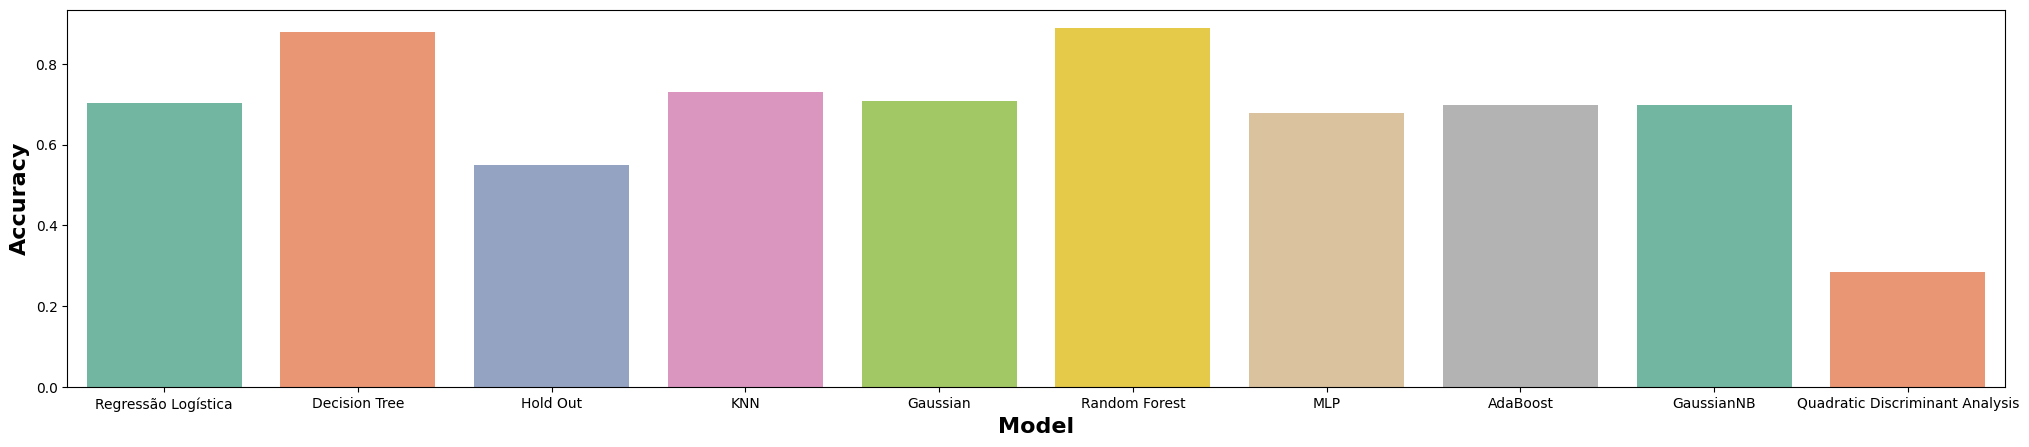

In [37]:
fig, ax = plt.subplots(figsize=(25, 5), dpi=100)
sns.barplot(x=results_plot['Model'] , y=results_plot['Accuracy'], ax=ax, palette='Set2')
ax.set_xlabel('Model', fontdict={'color':'black', 'weight':'bold', 'size': 16})
ax.set_ylabel('Accuracy', fontdict={'color':'black', 'weight':'bold', 'size': 16})

Text(0, 0.5, 'Precision')

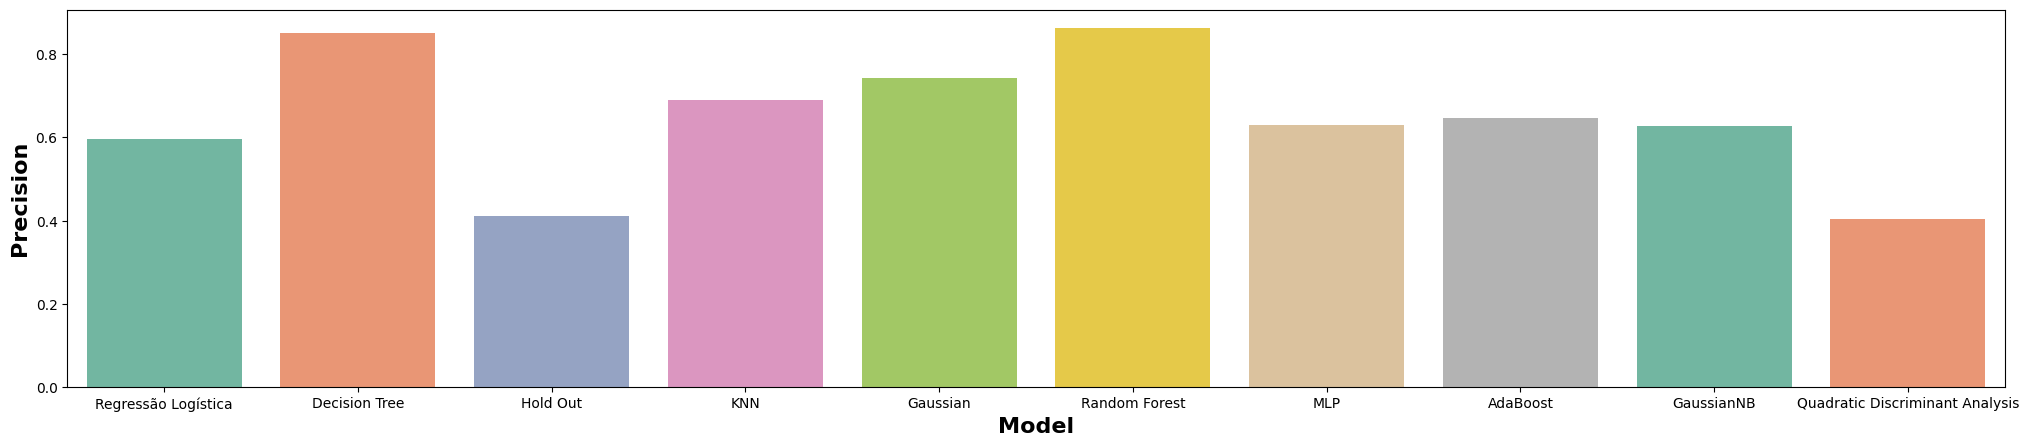

In [38]:
fig, ax = plt.subplots(figsize=(25, 5), dpi=100)
sns.barplot(x=results_plot['Model'] , y=results_plot['Precision'], ax=ax, palette='Set2')
ax.set_xlabel('Model', fontdict={'color':'black', 'weight':'bold', 'size': 16})
ax.set_ylabel('Precision', fontdict={'color':'black', 'weight':'bold', 'size': 16})

Text(0, 0.5, 'Recall')

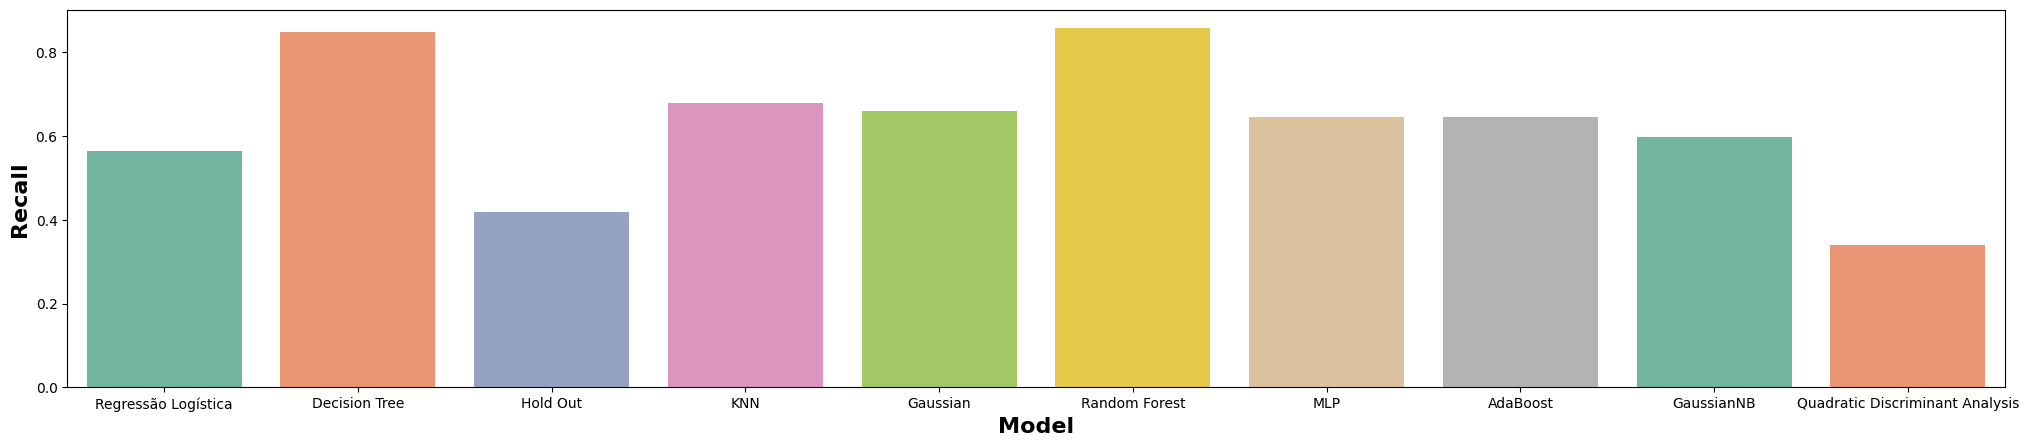

In [39]:
fig, ax = plt.subplots(figsize=(25, 5), dpi=100)
sns.barplot(x=results_plot['Model'] , y=results_plot['Recall'], ax=ax, palette='Set2')
ax.set_xlabel('Model', fontdict={'color':'black', 'weight':'bold', 'size': 16})
ax.set_ylabel('Recall', fontdict={'color':'black', 'weight':'bold', 'size': 16})

Text(0, 0.5, 'F1-Score')

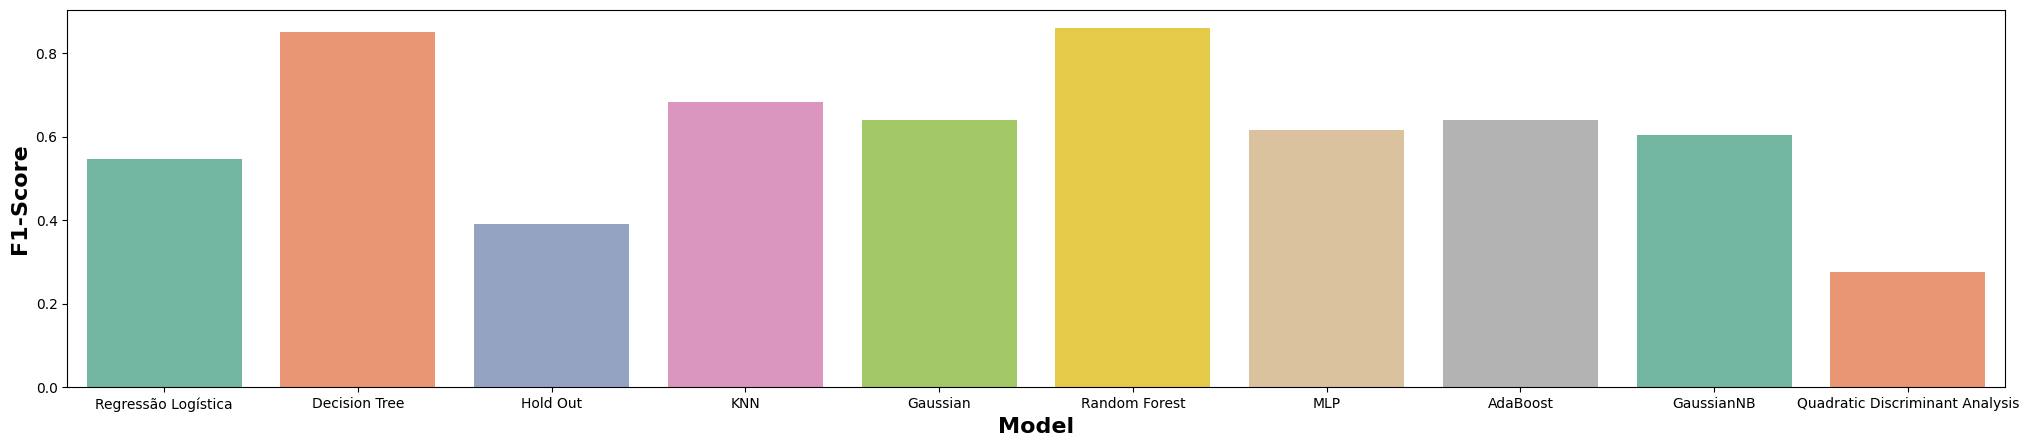

In [40]:
fig, ax = plt.subplots(figsize=(25, 5), dpi=100)
sns.barplot(x=results_plot['Model'] , y=results_plot['F1-Score'], ax=ax, palette='Set2')
ax.set_xlabel('Model', fontdict={'color':'black', 'weight':'bold', 'size': 16})
ax.set_ylabel('F1-Score', fontdict={'color':'black', 'weight':'bold', 'size': 16})